# SuperKEKB Lattice Troubleshooting

Author(s):      John Salvesen, based on code from Giovani Iadarola
Created:        22/04/2024
Last Edited:    22/04/2024

## Python Setup

### Packages

In [1]:
import json
import numpy as np
import xtrack as xt
import xplt
import matplotlib.pyplot as plt
import pandas as pd

### User Variables

In [2]:
fname               = 'sler_1705_60_06_cw50_4b.json'
twiss_fname         = 'sler_1705_60_06_cw50_4b.twiss.json'
survey_fname        = 'sler_1705_60_06_cw50_4b.dispg.json'
ref_particle_p0c    = 4e9

## Convert SAD to XTrack Elements

### Open SAD file and build dict

In [3]:
with open("json/" + fname, 'r', encoding="utf-8") as parsed_sad:
    d = json.load(parsed_sad)

imported_elems = {}

In [4]:
sad_element_types = {}
for key in d.keys():
    if key =='line':
        continue
    sad_element_types[key] = list(d[key].keys())
sad_element_types = [(key, value) for key, values in sad_element_types.items() for value in values]
sad_element_types = pd.DataFrame(sad_element_types, columns=['SAD_element_type', 'name'])

### Drifts

In [6]:
drifts = d['drift']
for nn, vv in drifts.items():
    assert len(vv.keys()) == 1
    imported_elems[nn] = xt.Drift(length=vv['l'])

### Bends

In [7]:
bends = d['bend']
bends_off = []
bends_on = []
for nn, vv in bends.items():
    if vv['angle'] == 0:
        bends_off.append(nn)
    else:
        bends_on.append(nn)

for nn in bends_off:
    vv = bends[nn]
    if 'l' in vv:
        imported_elems[nn] = xt.Drift(length=vv['l'])
    else:
        imported_elems[nn] = xt.Marker()

for nn in bends_on:
    vv = bends[nn]

    length = vv['l']
    angle = vv['angle']
    h = angle / length
    k0 = h

    oo = []
    if 'rotate' in vv:
        assert vv['rotate'] == 90 or vv['rotate'] == -90
        oo.append(xt.SRotation(angle=-vv['rotate']))

    if 'e1' in vv:
        # assert vv['fringe'] == 1
        # we put fringes everywhere (check what happens if fringe is not there)
        oo.append(xt.DipoleEdge(k=k0, e1=vv['e1']*angle,
                                hgap=1/6, #linear drop-off (see madx manual)
                                fint=vv['f1'],
                                side='entry'))

    oo.append(xt.Bend(k0=k0, h=h, length=length))

    if 'e2' in vv:
        oo.append(xt.DipoleEdge(k=k0, e1=vv['e2']*angle,
                                hgap=1/6, #linear drop-off (see madx manual)
                                fint=vv['f1'],
                                side='exit'))

    if 'rotate' in vv:
        oo.append(xt.SRotation(angle=vv['rotate']))

    imported_elems[nn] = oo

### Quadrupoles

In [8]:
for nn, vv in d['quad'].items():
    if 'rotate' in vv:
        assert np.abs(vv['rotate']) == 45
        # TODO: neglecting skew for not
        imported_elems[nn] = xt.Drift(length=vv['l'])
    imported_elems[nn] = xt.Quadrupole(length=vv['l'], k1=vv['k1']/vv['l'])
    # TODO: neglecting fringes for now

### Multipoles

In [9]:
for nn, vv in d['mult'].items():
    # TODO neglecting multipoles for now
    imported_elems[nn] = xt.Drift(length=vv.get('l', 0))

### Octupoles

In [10]:
for nn, vv in d['oct'].items():
    assert 'l' not in vv
    # TODO neglecting octupoles for now
    imported_elems[nn] = xt.Marker()

### Cavities

In [11]:
for nn, vv in d['cavi'].items():
    assert 'l' not in vv
    # TODO neglecting cavities for now
    imported_elems[nn] = xt.Marker()

### Monitors

In [12]:
for nn, vv in d['moni'].items():
    assert 'l' not in vv
    imported_elems[nn] = xt.Marker()

### Markers

In [13]:
for nn, vv in d['mark'].items():
    assert 'l' not in vv
    imported_elems[nn] = xt.Marker()

### Apertures

In [14]:
for nn, vv in d['apert'].items():
    assert 'l' not in vv
    imported_elems[nn] = xt.Marker()

### Solenoid

In [15]:
if 'sol' in d:
    for nn, vv in d['sol'].items():
        assert 'l' not in vv
        # TODO neglecting solenoids for now
        imported_elems[nn] = xt.Marker()

### Beam Beam

In [16]:
if 'beambeam' in d:
    for nn, vv in d['beambeam'].items():
        assert 'l' not in vv
        # TODO neglecting beambeam for now
        imported_elems[nn] = xt.Marker()

## Correct Converted Elements

In [17]:
element_names = []
elements = []
element_counts = {}
for nn in d['line']:
    if nn.startswith('-'):
        inverted = True
        nn = nn[1:]
    else:
        inverted = False

    if nn not in element_counts:
        element_counts[nn] = 1
    else:
        element_counts[nn] += 1

    if element_counts[nn] == 0:
        xs_name = nn
    else:
        xs_name = nn + '.' + str(element_counts[nn])

    to_insert = imported_elems[nn]

    if inverted:
        to_insert_inverted = []
        if not isinstance(to_insert, list):
            to_insert = [to_insert]
        for ee in to_insert:
            assert isinstance(ee, (xt.Drift, xt.Marker, xt.Bend, xt.Quadrupole,
                                      xt.SRotation, xt.DipoleEdge))
            if isinstance(ee, xt.Bend):
                ee = ee.copy()
                # ee.h *= -1
                # ee.k0 *= -1
            elif isinstance(ee, xt.DipoleEdge):
                ee = ee.copy()
                # ee.k *= -1
                # ee.e1 *= -1
                # ee.side = 'entry' if ee.side == 'exit' else 'exit'
            # elif isinstance(ee, xt.Quadrupole):
            #     ee = ee.copy()
            #     ee.k1 *= -1
            elif isinstance(ee, xt.SRotation):
                ee = ee.copy()
                ee.angle *= -1
            to_insert_inverted.append(ee)

        to_insert = to_insert_inverted
        if len(to_insert) == 1:
            to_insert = to_insert[0]

    if isinstance(to_insert, list):
        for iee, ee in enumerate(to_insert):
            elements.append(ee.copy())
            element_names.append(xs_name + ':' + str(iee))
    else:
        elements.append(to_insert.copy())
        element_names.append(xs_name)

## Create XTrack Line

In [18]:
line = xt.Line(elements=elements, element_names=element_names)
line.particle_ref = xt.Particles(p0c=ref_particle_p0c, mass0=xt.ELECTRON_MASS_EV)

### Build Tracker

In [19]:
line.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


## SAD Twiss and Survey

### Survey

In [20]:
with open(f'json/{survey_fname}', 'r') as f:
    sv_sad = json.load(f)
sv_sad = pd.DataFrame(sv_sad)

### Twiss

In [21]:
with open("json/" + twiss_fname, 'r', encoding="utf-8") as f:
    tw_dict = json.load(f)

tw_dict['Element'] = np.array([nn.lower() for nn in tw_dict['Element']])

tw_sad = xt.Table(
        {
            'name': np.array(tw_dict['Element']),
            's':    np.array(tw_dict['s(m)']),
            'betx': np.array(tw_dict['BX']),
            'alfx': np.array(tw_dict['AX']),
            'bety': np.array(tw_dict['BY']),
            'alfy': np.array(tw_dict['AY']),
            'mux':  np.array(tw_dict['NX']),
            'muy':  np.array(tw_dict['NY']),
            'dx':   np.array(tw_dict['EX']),
            'dy':   np.array(tw_dict['EY']),
            'dpx':  np.array(tw_dict['EPX']),
            'dpy':  np.array(tw_dict['EPY']),
        })

tt = line.get_table()
elems_in_common = np.intersect1d(tw_sad['name'], tt.name)

tt_common = tt.rows[elems_in_common]
tsad_common = tw_sad.rows[elems_in_common]

## XSuite Twiss and Survey

### Survey

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


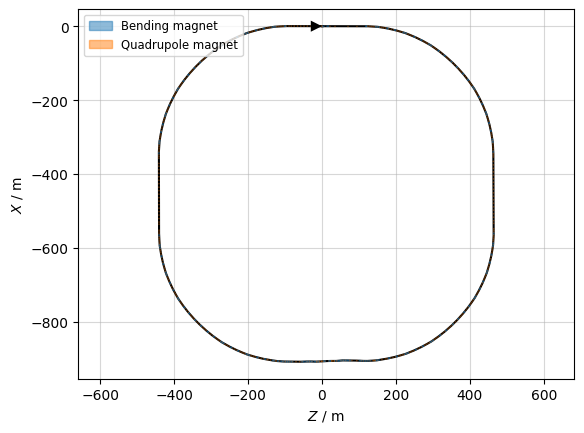

In [22]:
sv_xs = line.survey()
xplt.FloorPlot(sv_xs, line)
plt.legend(fontsize='small', loc='upper left')
plt.show()

### Twiss

In [23]:
tw_xs = line.twiss(
    _continue_if_lost   = True,
    start               = line.element_names[0],
    end                 = line.element_names[-1],
    init                = xt.TwissInit(betx=tw_sad['betx'][0],
    alfx                = tw_sad['alfx'][0],
    bety                = tw_sad['bety'][0],
    alfy                = tw_sad['alfy'][0],
    dx                  = tw_sad['dx'][0],
    dy                  = tw_sad['dy'][0],
    dpx                 = tw_sad['dpx'][0],
    dpy                 = tw_sad['dpy'][0])
)

betx_sad = np.interp(tw_xs.s, tw_sad.s, tw_sad.betx)
bety_sad = np.interp(tw_xs.s, tw_sad.s, tw_sad.bety)

Found suitable prebuilt kernel `default_only_xtrack`.


## Plots

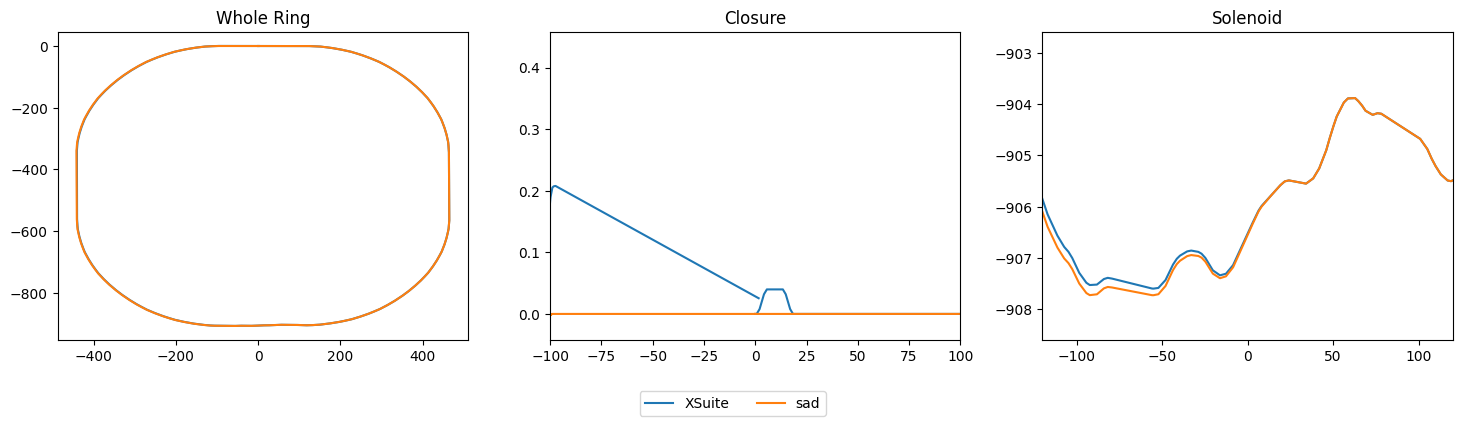

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

axs[0].plot(sv_xs.Z, sv_xs.X, label='XSuite')
axs[0].plot(sv_sad['Gx'], -np.array(sv_sad['Gy']), label='sad')
axs[0].set_title('Whole Ring')

axs[1].plot(sv_xs.Z, sv_xs.X)
axs[1].plot(sv_sad['Gx'], -np.array(sv_sad['Gy']))
axs[1].set_xlim(-100, 100)
axs[1].set_ylim(max(sv_xs.X) - 0.25, max(sv_xs.X) + 0.25)
axs[1].set_title('Closure')

axs[2].plot(sv_xs.Z, sv_xs.X)
axs[2].plot(sv_sad['Gx'], -np.array(sv_sad['Gy']))
axs[2].set_xlim(-120, 120)
axs[2].set_ylim(min(sv_xs.X) - 1, min(sv_xs.X) + 5)
axs[2].set_title('Solenoid')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
plt.show()

<Figure size 640x480 with 0 Axes>

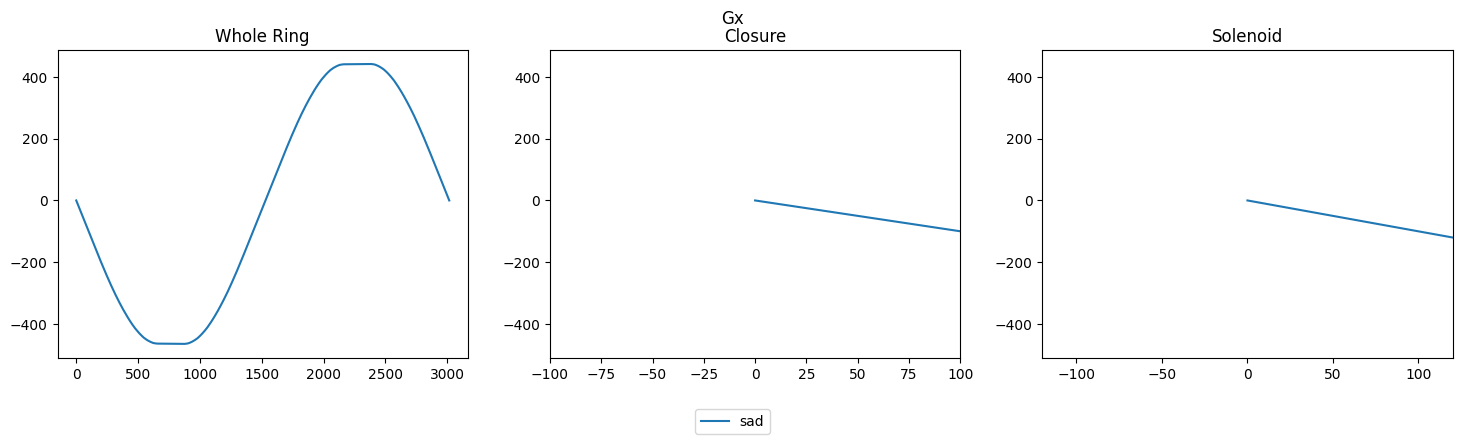

In [68]:
plt.clf()
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

fig.suptitle('Gx')

axs[0].plot(sv_sad['s'], -np.array(sv_sad['Gx']), label='sad')
axs[0].set_title('Whole Ring')

axs[1].plot(sv_sad['s'], -np.array(sv_sad['Gx']))
axs[1].set_xlim(-100, 100)
axs[1].set_title('Closure')

axs[2].plot(sv_sad['s'], -np.array(sv_sad['Gx']))
axs[2].set_xlim(-120, 120)
axs[2].set_title('Solenoid')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
plt.show()

<Figure size 640x480 with 0 Axes>

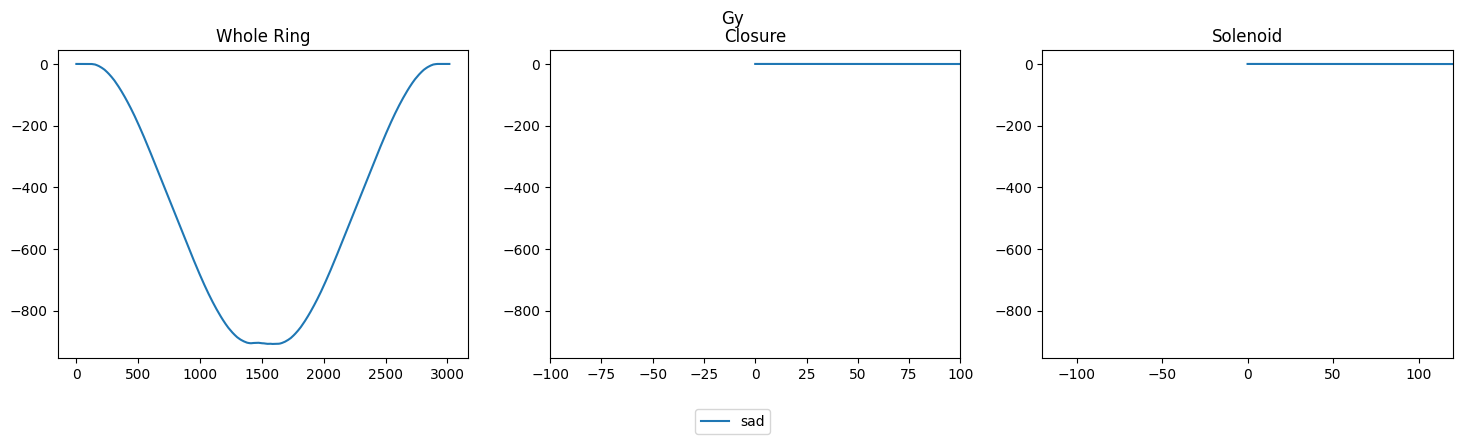

In [69]:
plt.clf()
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

fig.suptitle('Gy')

axs[0].plot(sv_sad['s'], -np.array(sv_sad['Gy']), label='sad')
axs[0].set_title('Whole Ring')

axs[1].plot(sv_sad['s'], -np.array(sv_sad['Gy']))
axs[1].set_xlim(-100, 100)
axs[1].set_title('Closure')

axs[2].plot(sv_sad['s'], -np.array(sv_sad['Gy']))
axs[2].set_xlim(-120, 120)
axs[2].set_title('Solenoid')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
plt.show()

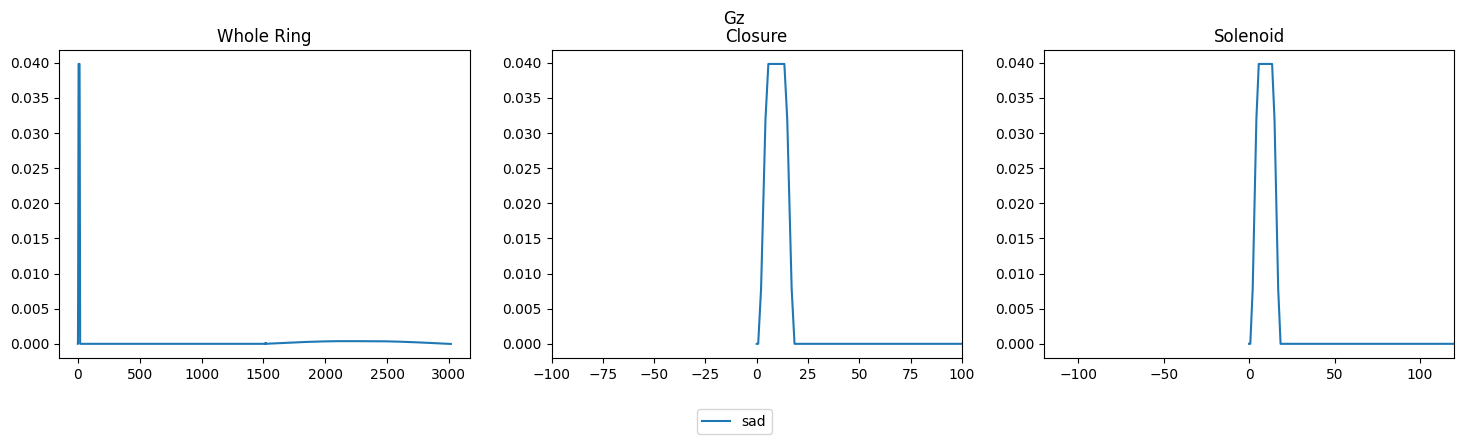

In [72]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

fig.suptitle('Gz')

axs[0].plot(sv_sad['s'], -np.array(sv_sad['Gz']), label='sad')
axs[0].set_title('Whole Ring')

axs[1].plot(sv_sad['s'], -np.array(sv_sad['Gz']))
axs[1].set_xlim(-100, 100)
axs[1].set_title('Closure')

axs[2].plot(sv_sad['s'], -np.array(sv_sad['Gz']))
axs[2].set_xlim(-120, 120)
axs[2].set_title('Solenoid')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
plt.show()

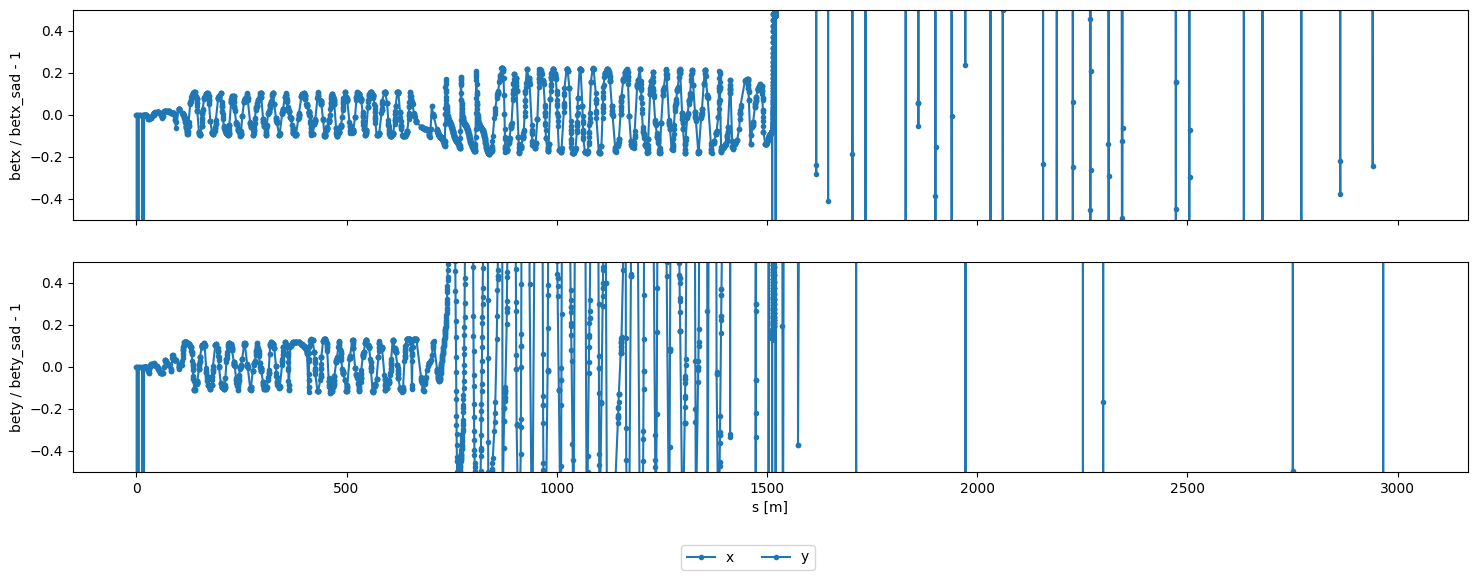

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(18, 6), sharex=True)

axs[0].plot(tw_xs.s, tw_xs.betx / betx_sad - 1, '.-', label='x')
axs[0].set_ylim(-0.5, 0.5)
axs[0].set_ylabel('betx / betx_sad - 1')

axs[1].plot(tw_xs.s, tw_xs.bety / bety_sad - 1, '.-', label='y')
axs[1].set_xlabel('s [m]')
axs[1].set_ylabel('bety / bety_sad - 1')
axs[1].set_ylim(-0.5, 0.5)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
plt.show()

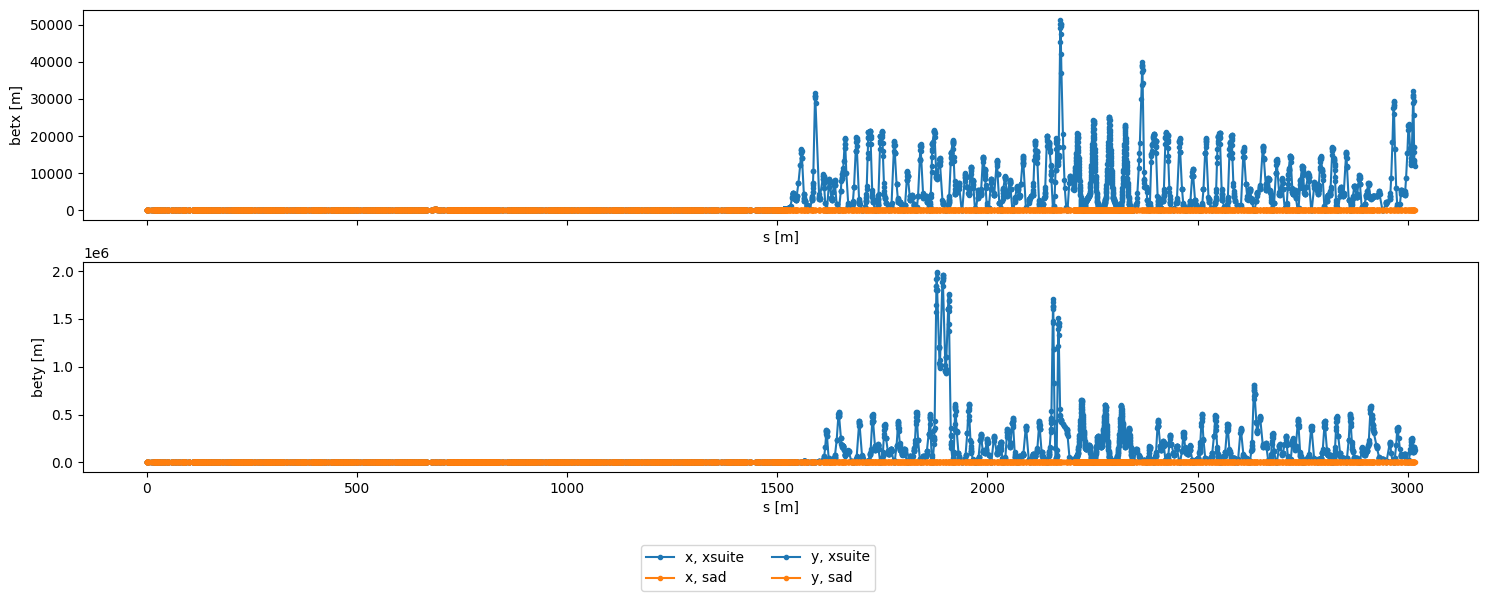

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(18, 6), sharex=True)

axs[0].plot(tw_xs.s, tw_xs.betx, '.-', label='x, xsuite')
axs[0].plot(tw_xs.s, betx_sad, '.-', label='x, sad')
axs[0].set_xlabel('s [m]')
axs[0].set_ylabel('betx [m]')

axs[1].plot(tw_xs.s, tw_xs.bety, '.-', label='y, xsuite')
axs[1].plot(tw_xs.s, bety_sad, '.-', label='y, sad')
axs[1].set_xlabel('s [m]')
axs[1].set_ylabel('bety [m]')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
plt.show()

# Sliding Test

In [27]:
def get_elements_at_pos(pos, pos_tol, xs_table, sad_table):
    ele_xs        = xs_table[(xs_table['s'] >= pos - pos_tol)]['name'].values[0]
    pos_ele_xs    = xs_table[(xs_table['s'] >= pos - pos_tol)]['s'].values[0]
    ele_sad       = sad_table[(sad_table['s'] >= pos_ele_xs - pos_tol)]['name'].values[0]

    return ele_xs, ele_sad

In [28]:
def calc_residuals(xs_data, sad_data, param):
    return np.abs((np.array(xs_data[param]) - np.array(sad_data[param])) / np.array(sad_data[param]))

In [29]:
def find_discrepancy_position(residual, discrepancy_tol, s_values, start_pos):
    differences = np.diff(np.log(residual))
    jumps       = np.where(differences > discrepancy_tol)[0]
    # The first element always jumps because set exactly and then numerical precision
    jumps   = jumps[jumps != 0.0]
    # Remove any jumps that happen when the residual is less that 0.1%
    jumps   = jumps[residual[jumps] > 0.001]
    if len(jumps) == 0:
        return np.nan
    else:
        jump_pos = np.array(s_values[jumps])
        jump_pos = jump_pos[jump_pos > start_pos]
        jump_pos    = jump_pos[0]
        return jump_pos

In [30]:
def find_discrepancy_position(residual, discrepancy_tol, s_values, start_pos):
    param_diffs = np.diff(np.log(residual))
    s_diffs     = np.diff(s_values)

    # Perform division, handling zero denominators
    diffs_per_s = np.divide(param_diffs, s_diffs, out=np.zeros_like(param_diffs), where=(s_diffs != 0))

    jumps       = np.where(diffs_per_s > discrepancy_tol)[0]
    # The first element always jumps because set exactly and then numerical precision
    jumps   = jumps[jumps != 0.0]
    # Remove any jumps that happen when the residual is less that 0.1%
    jumps   = jumps[residual[jumps] > 0.001]
    if len(jumps) == 0:
        return np.nan
    else:
        jump_pos = np.array(s_values[jumps])
        jump_pos = jump_pos[jump_pos > start_pos]
        jump_pos    = jump_pos[0]
        return jump_pos

In [31]:
def find_min_positions(arr):
    min_item = np.nanmin(arr)
    min_positions = [i for i, x in enumerate(arr) if x == min_item]
    return min_positions

In [32]:
def plot_segment(params, filtered_xs, filtered_sad, jump_pos, residuals):
    fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    axs2 = [axs[i].twinx() for i in range(4)]

    for i, param in enumerate(params):
        axs[i].plot(filtered_xs.s, filtered_xs[param], label='xtrack')
        axs[i].plot(filtered_sad.s, filtered_sad[param], label='sad')
        if jump_pos:
            axs[i].axvline(x=jump_pos, color='r', linestyle='--', label='jump')
        axs[i].set_ylabel(param)
        axs2[i].plot(filtered_xs.s, residuals[i], c='g', label='residual')
        axs2[i].set_ylabel('residual')
        axs2[i].set_yscale('log')
        axs2[i].set_ylim(1E-6, 1E2)

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=3)
    plt.show()

In [33]:
def scan_machine_for_discrepancies(
    iteration_dist,
    discrepancy_tol,
    pos_tol,
    params_to_analyse = ['betx', 'bety', 'dx', 'dy'],
    start_pos = 0.0,
    plot = True,
    skip_after_error = 0.1
):

    broken_elements = []

    xs_table    = line.get_table().to_pandas()
    sad_table   = tw_sad.to_pandas()

    # List of common elements
    elems_in_common = np.intersect1d(xs_table.name, sad_table.name)
    xs_table_common = xs_table[xs_table['name'].isin(elems_in_common)]
    sad_table_common = sad_table[sad_table['name'].isin(elems_in_common)]
    
    end_pos     = start_pos + iteration_dist

    while end_pos < xs_table['s'].iloc[-1]:
        # Get start and end elements
        # These need to be only from elements in common
        ele_start_xs, ele_start_sad = get_elements_at_pos(start_pos, pos_tol, xs_table_common, sad_table_common)
        ele_stop_xs, ele_stop_sad   = get_elements_at_pos(end_pos, pos_tol, xs_table_common, sad_table_common)

        # Survey
        # subset_sv_xs    = sv_xs.rows[sv_xs.s >= pos_ele_start_xs, sv_xs.s <= pos_ele_stop_xs]
        # subset_sv_sad   = sv_sad[(sv_sad['s'] >= pos_ele_start_xs) & (sv_sad['s'] <= pos_ele_stop_xs)]

        # Twiss
        subset_tw_xs = line.twiss(
            _continue_if_lost   = True,
            start               = ele_start_xs,
            end                 = ele_stop_xs,
            init                = xt.TwissInit(
                betx                = tw_sad['betx', ele_start_sad],
                alfx                = tw_sad['alfx', ele_start_sad],
                bety                = tw_sad['bety', ele_start_sad],
                alfy                = tw_sad['alfy', ele_start_sad],
                dx                  = tw_sad['dx', ele_start_sad],
                dy                  = tw_sad['dy', ele_start_sad],
                dpx                 = tw_sad['dpx', ele_start_sad],
                dpy                 = tw_sad['dpy', ele_start_sad]
            )
        )

        # Subset within length range
        subset_tw_xs    = subset_tw_xs.rows[start_pos : end_pos:'s']
        subset_tw_sad   = tw_sad.rows[start_pos : end_pos:'s']

        # Find common elements
        elems_in_common = np.intersect1d(subset_tw_xs.name, subset_tw_sad.name)

        filtered_xs = subset_tw_xs.rows[elems_in_common]
        filtered_sad = subset_tw_sad.rows[elems_in_common]

        # Residuals
        residuals = [
            calc_residuals(
                xs_data     = filtered_xs,
                sad_data    = filtered_sad,
                param       = param
            )
            for param in params_to_analyse
        ]

        # Find any discrepancies
        discrepancy_positions = [
            find_discrepancy_position(
                residual        = residual,
                discrepancy_tol = discrepancy_tol,
                s_values        = filtered_xs.s,
                start_pos       = start_pos
            )
            for residual in residuals
        ]

        if len(discrepancy_positions) > 0:
            # Find minimum discrepancy position
            min_discrepancy_pos = np.nanmin(discrepancy_positions)
            if (min_discrepancy_pos > start_pos) & (min_discrepancy_pos < end_pos):
                discrepancy_types = [params_to_analyse[i] for i in find_min_positions(discrepancy_positions)]
                broken_xs, broken_sad = get_elements_at_pos(min_discrepancy_pos, pos_tol, xs_table_common, sad_table_common)
                segment_dict = {
                    'start_pos':            start_pos,
                    'end_pos':              end_pos,
                    'min_discrepancy_pos':  min_discrepancy_pos,
                    'broken_xs':            broken_xs,
                    'broken_sad':           broken_sad,
                    'discrepancy_types':    discrepancy_types,
                    'element_type':         xs_table.loc[xs_table['name'] == broken_xs].element_type.values[0]
                }
                broken_elements.append(segment_dict)

                distance_along = min_discrepancy_pos - start_pos
                start_pos   += distance_along + skip_after_error
                end_pos     += distance_along + skip_after_error

            else:
                min_discrepancy_pos = None
                print("No discrepancies found")
                start_pos   += iteration_dist
                end_pos     += iteration_dist
        else:
            min_discrepancy_pos = None
            print("No discrepancies found")
            start_pos   += iteration_dist
            end_pos     += iteration_dist

        if plot:
            plot_segment(params_to_analyse, filtered_xs, filtered_sad, min_discrepancy_pos, residuals)
        

    broken_elements = pd.DataFrame(broken_elements)
    return broken_elements

broken_elements = scan_machine_for_discrepancies(
    iteration_dist      = 200,
    discrepancy_tol     = 3,
    pos_tol             = 0.01,
    params_to_analyse   = ['betx', 'bety', 'dx', 'dy'],
    start_pos           = 102,
    plot                = False
)

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


/var/folders/vw/g5f93yf13pv2lpspzd_rzsfh0000gn/T/ipykernel_35231/2701713053.py:2: RuntimeWarning: divide by zero encountered in log
  param_diffs = np.diff(np.log(residual))


Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


/Users/jack/miniconda3/envs/xsuite/lib/python3.11/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kern

In [34]:
print(broken_elements)

       start_pos      end_pos  min_discrepancy_pos  broken_xs broken_sad  \
0     102.000000   302.000000           111.082074   lx0828.2   lx0828.2   
1     111.182074   311.182074           200.809372     db2p.8     db2p.8   
2     200.909372   400.909372           210.088167    lx278.5    lx278.5   
3     210.188167   410.188167           214.240037  lx0828.13  lx0828.13   
4     214.340037   414.340037           219.988642   lx097.14   lx097.14   
..           ...          ...                  ...        ...        ...   
290  2673.004156  2873.004156          2762.202656   db2p.186   db2p.186   
291  2762.302656  2962.302656          2778.918097  lxb2p.187  lxb2p.187   
292  2779.018097  2979.018097          2786.071591   lx278.92   lx278.92   
293  2786.171591  2986.171591          2787.421791   lx526.69   lx526.69   
294  2787.521791  2987.521791          2855.062892  lxb2p.195  lxb2p.195   

    discrepancy_types element_type  
0                [dx]        Drift  
1            

In [35]:
broken_elements = scan_machine_for_discrepancies(
    iteration_dist      = 200,
    discrepancy_tol     = 3,
    pos_tol             = 0.01,
    params_to_analyse   = ['betx', 'bety'],
    start_pos           = 102,
    plot                = False
)
print(broken_elements.element_type.value_counts())
print(broken_elements.discrepancy_types.value_counts())

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


/var/folders/vw/g5f93yf13pv2lpspzd_rzsfh0000gn/T/ipykernel_35231/2701713053.py:2: RuntimeWarning: divide by zero encountered in log
  param_diffs = np.diff(np.log(residual))


Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
No discrepancies found
Found suitable prebuilt kernel `default_only_xtrack`.


/var/folders/vw/g5f93yf13pv2lpspzd_rzsfh0000gn/T/ipykernel_35231/3590042689.py:83: RuntimeWarning: All-NaN axis encountered
  min_discrepancy_pos = np.nanmin(discrepancy_positions)


Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
No discrepancies found
Found

## Test if Elements are missing

In [36]:
xs_table    = line.get_table().to_pandas()
sad_table   = tw_sad.to_pandas()

### Add in the correct sad element types to the table

In [37]:
valid_names = sad_element_types['name'].values

def clean_name(name):
    matched_name = None
    for valid_name in valid_names:
        if valid_name in name:
            if matched_name is None or len(valid_name) > len(matched_name):
                matched_name = valid_name
    return matched_name

sad_table['clean_name'] = sad_table['name'].apply(clean_name)
sad_element_types['clean_name'] = sad_element_types['name'].apply(clean_name)
sad_element_types.drop('name', axis=1, inplace=True)

sad_table = pd.merge(sad_table, sad_element_types, on='clean_name', how='left')
sad_table.drop('clean_name', axis=1, inplace=True)

print(sad_table)

            name            s     betx      alfx      bety     alfy       mux  \
0        pfbmon1     0.000000  55.4339   1.60106  12.11740  0.56897   0.00000   
1         lv3p.1     0.000000  55.4339   1.60106  12.11740  0.56897   0.00000   
2         bv2p.1     0.718000  53.1679   1.55490  11.35660  0.49053   0.00210   
3         lvb1.1     2.118000  48.9405   1.46906  10.19590  0.33759   0.00647   
4         bv1p.1     4.273128  42.9082   1.32999   9.24834  0.10213   0.01396   
...          ...          ...      ...       ...       ...      ...       ...   
8090      qv1p.2  3014.814100  66.6408  15.92710  12.70030 -2.16250  44.52590   
8091  lx097b.127  3015.274880  58.8056   1.66737  13.40750  0.68166  44.52710   
8092     zvqv1p1  3015.372290  58.4814   1.66111  13.27580  0.67102  44.52730   
8093      lv4p.2  3015.716690  57.3448   1.63897  12.82650  0.63340  44.52830   
8094         $$$  3016.306490  55.4339   1.60106  12.11740  0.56897  44.52990   

           muy        dx   

In [38]:
nearby_elements_xs = xs_table[
    (xs_table['s'] >= broken_elements.min_discrepancy_pos[0] - 10) &\
    (xs_table['s'] <= broken_elements.min_discrepancy_pos[0] + 1E-2)
]

print(nearby_elements_xs[['s', 'name', 'element_type']])
print(len(nearby_elements_xs.name.values))

              s         name element_type
458  256.064123      b2p.7:2   DipoleEdge
459  256.064123      db2p.14        Drift
460  256.064123     lxb2p.14        Drift
461  256.079072        l2p.3        Drift
462  256.863838   zhqf2p27.1        Drift
463  257.208238     lx097.19        Drift
464  257.304903       qf2p.3   Quadrupole
465  257.767173    lp1689.20        Drift
466  257.936038    mqf2p27.1       Marker
467  257.936038    lx0828.17        Drift
468  258.018838  lzvqf2p27.1        Drift
469  258.363238       l1ph.2        Drift
470  263.602118  lzhqd1p14.1        Drift
471  263.946518    lx0828.18        Drift
472  264.029318    mqd1p14.1       Marker
473  264.029318    lp1696.11        Drift
16


In [39]:
nearby_elements_sad = sad_table[
    (sad_table['s'] >= broken_elements.min_discrepancy_pos[0] - 10) &\
    (sad_table['s'] <= broken_elements.min_discrepancy_pos[0] + 1E-2)
]

print(nearby_elements_sad[['s', 'name', 'SAD_element_type']])
print(len(nearby_elements_sad.name.values))

              s       name SAD_element_type
427  256.064123    db2p.14             mult
428  256.064123   lxb2p.14            drift
429  256.079072      l2p.3            drift
430  256.863838   zhqf2p27             bend
431  257.208238   lx097.19            drift
432  257.304903     qf2p.3             quad
433  257.767173  lp1689.20            drift
434  257.936038    mqf2p27             moni
435  257.936038  lx0828.17            drift
436  258.018838  lzvqf2p27            drift
437  258.363238     l1ph.2            drift
438  263.602118  lzhqd1p14            drift
439  263.946518  lx0828.18            drift
440  264.029318    mqd1p14             moni
441  264.029318  lp1696.11            drift
15


### Bend off here might be an issue?

# Rotation Elements

In [53]:
print(sad_table[(sad_table['s'] < 10)][['s', 'name', 'SAD_element_type']])

          s     name SAD_element_type
0  0.000000  pfbmon1             mark
1  0.000000   lv3p.1            drift
2  0.718000   bv2p.1             bend
3  2.118000   lvb1.1            drift
4  4.273128   bv1p.1             bend
5  5.673128   lvb2.1            drift
6  9.573128     pmid             mark
7  9.573128   lvb2.2            drift


In [54]:
print(xs_table[(xs_table['s'] < 10)][['s', 'name', 'element_type']])

           s       name element_type
0   0.000000  pfbmon1.1       Marker
1   0.000000     lv3p.1        Drift
2   0.718000   bv2p.1:0    SRotation
3   0.718000   bv2p.1:1         Bend
4   2.118000   bv2p.1:2   DipoleEdge
5   2.118000   bv2p.1:3    SRotation
6   2.118000     lvb1.1        Drift
7   4.273128   bv1p.1:0    SRotation
8   4.273128   bv1p.1:1   DipoleEdge
9   4.273128   bv1p.1:2         Bend
10  5.673128   bv1p.1:3    SRotation
11  5.673128     lvb2.1        Drift
12  9.573128     pmid.1       Marker
13  9.573128     lvb2.2        Drift


In [59]:
line['bv2p.1:0']


SRotation(cos_z=6.12e-17, sin_z=1)

In [58]:
line['bv2p.1:1']

Bend(length=1.4, k0=-0.008, k1=0, h=-0.008, model='adaptive', knl=array([0., 0., 0., 0., 0.]), ksl=array([0., 0., 0., 0., 0.]), edge_entry_active=1, edge_exit_active=1, edge_entry_model='linear', edge_exit_model='linear', edge_entry_angle=0, edge_exit_angle=0, edge_entry_angle_fdown=0, edge_exit_angle_fdown=0, edge_entry_fint=0, edge_exit_fint=0, edge_entry_hgap=0, edge_exit_hgap=0, shift_x=0, shift_y=0, rot_s_rad=0)